In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, multivariate_normal
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tqdm import trange
from densratio import densratio
from numpy import linalg as la
import matplotlib.pyplot as plt
from densratio import densratio
np.random.seed(None)
import momentchi2 as mchi

# Functions

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso

    

def density_ratio_estimate_prob_RF(D_nu, D_de, n_estimators=100):
    l_nu = np.ones(len(D_nu))
    l_de = np.zeros(len(D_de))
    
    l = np.concatenate((l_nu, l_de))
    D = np.concatenate((D_nu, D_de))
    
    # Fit Random Forest model
    model = RandomForestClassifier()
    model.fit(D, l)
    
    # Get density ratios for all samples
    density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
    
    return density_ratios


from sklearn.linear_model import LogisticRegressionCV

def density_ratio_estimate_prob_LR(D_nu, D_de, true_density = None,Z_known = True):
    if Z_known == False:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Adding cross terms
        cross_terms_de = []
        n_covariates = D_de.shape[1]
        for i in range(n_covariates):
            for j in range(i, n_covariates):
                cross_term = D_de[:, i] * D_de[:, j]
                cross_terms_de.append(cross_term)
        cross_terms_de = np.array(cross_terms_de).T

        cross_terms_nu = []
        n_covariates = D_nu.shape[1]
        for i in range(n_covariates):
            for j in range(i , n_covariates):
                cross_term = D_nu[:, i] * D_nu[:, j]
                cross_terms_nu.append(cross_term)
        cross_terms_nu = np.array(cross_terms_nu).T


        D_nu_with_cross_terms = np.concatenate((D_nu, cross_terms_nu),axis = 1)
        D_de_with_cross_terms = np.concatenate((D_de, cross_terms_de), axis = 1)
        D_with_cross_terms = np.concatenate((D_nu_with_cross_terms, D_de_with_cross_terms))

        # Fit logistic model with cross terms
        C = 0.1
        model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
        model.fit(D_with_cross_terms, l)

        # Get density ratios for samples in D_de
        density_ratios = (model.predict_proba(D_de_with_cross_terms)[:, 1] / model.predict_proba(D_de_with_cross_terms)[:, 0]) * (len(D_de) / len(D_nu))
        
    if Z_known == True:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Fit logistic model with cross terms

        model = LogisticRegressionCV(penalty='l2', cv = 2)
        model.fit(D, l)
        print(model.score(D,l))
        # Get density ratios for samples in D_de
        v_density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
        density_ratios = v_density_ratios * np.array(true_density)
    return density_ratios





from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

def est_v_ratio(X_s, Z_s, V_s, X_t, Z_t, V_t, test_size=0.2):
    # Train-test split for source domain
    X_s_train, X_s_test, Z_s_train, Z_s_test, V_s_train, V_s_test = train_test_split(
        X_s, Z_s, V_s, test_size=test_size, random_state=42
    )
   

    # Concacanate the X and Z data
    D_s_train = np.concatenate((Z_s_train, X_s_train), axis=1)
    model_s = LassoCV(cv=5)
    model_s.fit(D_s_train, V_s_train.ravel())

    # Estimate the variance of the V|X,Z model for testing data
    D_s_test = np.concatenate((Z_s_test, X_s_test), axis=1)
    V_pred_s_test = model_s.predict(D_s_test)
    residual_s_test = V_s_test.ravel() - V_pred_s_test
    est_var_s_test = np.var(residual_s_test)

    # Estimate the V probability for each sample in the testing set
    V_s_prob_test = norm.pdf(V_s_test.ravel(), loc=V_pred_s_test, scale=np.sqrt(est_var_s_test))

    # Train-test split for target domain
    X_t_train, X_t_test, Z_t_train, Z_t_test, V_t_train, V_t_test = train_test_split(
        X_t, Z_t, V_t, test_size=test_size, random_state=42
    )

    # Generate cross-terms between X_t and Z_t for training data
    D_t_train = np.concatenate((Z_t_train, X_t_train), axis=1)
    model_t = LassoCV(cv=5)
    model_t.fit(D_t_train, V_t_train.ravel())

    # Estimate the variance of the V|X,Z model for testing data
    D_t_test = np.concatenate((Z_t_test, X_t_test), axis=1)
    V_pred_t_test = model_t.predict(D_t_test)
    residual_t_test = V_t_test.ravel() - V_pred_t_test
    est_var_t_test = np.var(residual_t_test)

    # Generate cross-terms between X_s and Z_t for testing data
    D_st_test = np.concatenate((Z_t_test, X_s_test), axis=1)
    V_pred_st_test = model_t.predict(D_st_test)

    V_t_prob_test = norm.pdf(V_s_test.ravel(), loc=V_pred_st_test, scale=np.sqrt(est_var_t_test))

    v_ratio_test = V_t_prob_test / V_s_prob_test

    return v_ratio_test

  

def norm_est_ratio(D_s, D_t):
    ns = D_s.shape[0]
    nt = D_t.shape[0]
    p = D_s.shape[1]
    
    ED_s = np.mean(D_s, axis=0)
    ED_t = np.mean(D_t, axis=0)
    
    CS = np.cov(D_s.T)
    CT = np.cov(D_t.T)
    
    pdf_s = multivariate_normal.pdf(D_s, mean=ED_s, cov=CS)
    pdf_t = multivariate_normal.pdf(D_s, mean=ED_t, cov=CT)
    
    true_ = pdf_t / pdf_s
    
    return true_

    


# def Covariate_Shift_Weight(x, z, v = 0):
#     return np.exp(((x - z @ s)**2 - (x - z @ t)**2)/2)

def Model_X(z, v, u):
    return z[:5] @ u + np.random.normal(0, 1, 1)

## group samples together

def T_statistic(y, x, z, v, u,s, t,regr):
#     d_y = regr.predict(z.reshape(1, z.shape[0]))
#     # d_y = (1+s)@z
    d_x = z[:5]@u
    
#     return np.abs(((y-d_y)*(x-d_x)))
    return y*(x-d_x)
    # return coef[0]

def Conterfeits(y, x, z, v, u,s, t, L, K, regr):
    M = L * K - 1
    cnt = 0
    t_stat = T_statistic(y, x, z, v, u,s, t,regr)

    for i in range(M):
        x_ = Model_X(z, v, u)
        if t_stat > T_statistic(y, x_, z, v, u,s, t, regr):
            cnt=cnt+1
            
    return cnt // K

def PCRtest( Y, X, Z, V, u, s, t, L, K, covariate_shift, density_ratio, regr):
    n = Y.size
    W = np.array([0.0]*L)


    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        if covariate_shift == True:
            ind = Conterfeits(y, x, z, v, u,s, t, L, K, regr)
            W[ind] += density_ratio[j]
           
                
        if covariate_shift == False:
            W[Conterfeits(y, x, z, v, u,s, t, L, K, regr)] += 1
            
    return W, L/n * np.dot(W - n/L, W - n/L)

def generate_cov_matrix(Y, X, Z, V,u, s, t, L, K, density_ratio, regr):
    """
    Generate a covariance matrix for quadratic form normal rv.

    Parameters:
    - L (int): The size of the covariance matrix.

    Returns:
    - covariance_matrix (ndarray): The generated covariance matrix.
    """
    n = Y.size
    diag = np.array([0.0]*L)
    
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        diag[Conterfeits(y, x, z, v, u,s,t,L, K, regr)] += (density_ratio[j]**2)
    diag = L*(diag/n)- 1/L
    covariance_matrix = np.full((L, L), -1/L)  # Fill all entries with 1/L
    np.fill_diagonal(covariance_matrix, diag)  # Set diagonal entries to 1 - 1/L^2
    return covariance_matrix


def PCRtest_Powen(Y, X, Z, V, Y_, X_, Z_, V_, u, s, t, L, K, density_ratio, regr):
    a, b, c = [], [], []
    W = np.array([0.0]*L)
    ns, nt = Y.size, Y_.size
    for j in range(ns):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        ind_y = Conterfeits(y, x, z, v, u, s, t, L, K, regr)
        ind_v = Conterfeits(v, x, z, v, u, s, t, L, K, regr)
        a.append(ind_y)
        b.append(ind_v)
    
    a = np.array(a)
    b = np.array(b)
    density_ratio=np.array(density_ratio).ravel()

    g = (a*density_ratio)@(b*density_ratio)/((b*density_ratio)@((b*density_ratio).T))
    
    for j in range(nt):
        y_, x_, z_, v_ = Y_[j], X_[j], Z_[j], V_[j]
        ind_v_ = Conterfeits(v_, x_, z_, v_, u, s, t, L, K, regr)
        W[ind_v_] += ns/nt*g
        c.append(ind_v_)

    c = np.array(c)
    for j in range(ns):
        W[a[j]] += density_ratio[j]
        W[b[j]] -= density_ratio[j]*g    

    return W, L/ns * np.dot(W - ns/L, W - ns/L), a, b, c, g

def I(a, b):
    if a == b:
        return 1
    else:
        return 0
    

def generate_cov_matrix_powen(ind_y_source, ind_v_source, ind_v_target ,gamma, L, K, density_ratio):
    ns = ind_y_source.size
    nt = ind_v_target.size

    cov_matrix = np.zeros((L, L))
    E_t = []
    E_s = []
    V_t = []
    for l in range(L):
        e = 0
        f = 0
        for i in range(nt):
            e += I(ind_v_target[i], l)
        for j in range(ns):
            f += float(density_ratio[j]*(I(ind_y_source[j], l) - gamma*I(ind_v_source[j], l)))
        E_t.append(e*gamma*ns/nt)
        V_t.append(e*(nt - e) * gamma**2 *ns**2 / (nt**3))
        E_s.append(f)

    for l_1 in range(L):
        for l_2 in range(l_1+1):
            e = 0
            for j in range(ns):
                ind_v_source[j]
                e += density_ratio[j]**2*(I(ind_y_source[j], l_1) - gamma*I(ind_v_source[j], l_1))*(I(ind_y_source[j], l_2) - gamma*I(ind_v_source[j], l_2))

            cov_matrix[l_1, l_2] = e - E_s[l_1]*E_s[l_2]/ns + I(l_1, l_2)*V_t[l_1] - (1 - I(l_1, l_2))*E_t[l_1]*E_t[l_2]/(nt**2)
            cov_matrix[l_2, l_1] = e - E_s[l_1]*E_s[l_2]/ns + I(l_1, l_2)*V_t[l_1] - (1 - I(l_1, l_2))*E_t[l_1]*E_t[l_2]/(nt**2)
    
#    print(V_t)
#    print(ind_y_source.sum(), ind_v_source.sum(), ind_v_target.sum())
    return cov_matrix*L/ns
   

In [3]:
#get p values

import scipy.stats as stats

def chi_squared_p_value(chi_squared_statistic, df):
    """
    Calculate the p-value from a chi-squared distribution.

    Parameters:
    - chi_squared_statistic (float): The observed chi-squared test statistic.
    - df (int): The degrees of freedom.

    Returns:
    - p_value (float): The calculated p-value.
    """
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, df)
    return p_value

def monte_carlo_p_value(n_samples, covariance_matrix, L, quantile):
    
    count = 0
    for _ in range(n_samples):
        sample = np.random.multivariate_normal(np.zeros(L), covariance_matrix)
        squared_sum = np.sum(sample**2)
        if squared_sum <= quantile:
            count += 1

    probability = count / n_samples
    return 1-probability




# 生成数据

In [4]:
# Generate Data


import numpy as np

def generate(ns, nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 2, effect = 1,z_diff = 0.1):
    Zs_null = np.random.normal(0,0.1, (ns, q))
    Zt_null = np.random.normal(0,0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect*V_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect*V_target + np.random.normal(0, 1, nt) 
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target




def generate_multiple(ns, nt, p, q, s, t, u_matrix, Alpha_s=np.zeros(10), Alpha_t=np.ones(10)):
    
    Zs_null = np.random.normal(0, 0.1, (ns, q))
    Zt_null = np.random.normal(0, 0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)), Zs_null))
    Z_target = np.hstack((np.random.normal(0.1, 1, (nt, p)), Zt_null))
    
    k = u_matrix.shape[1]  # Number of different u vectors
    X_source = np.zeros((ns, k))
    X_target = np.zeros((nt, k))
    
    for i in range(k):
        X_source[:, i] = (Z_source[:, :p] @ u_matrix[:, i]) + np.random.normal(0, 1, ns)
        X_target[:, i] = (Z_target[:, :p] @ u_matrix[:, i]) + np.random.normal(0, 1, nt)

    V_source = (Z_source[:, :p] @ s) + (X_source @ Alpha_s) + np.random.normal(0, 5, ns)
    V_target = (Z_target[:, :p] @ t) + (X_target @ Alpha_t) + np.random.normal(0, 5, nt)
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + V_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + V_target + np.random.normal(0, 1, nt) 
    
    return Y_source.reshape(-1, 1), X_source, V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target, V_target.reshape(-1, 1), Z_target






def true_density_ratio(X, Z, V, s, t,p,q, Alpha_s = 0, Alpha_t = 2,z_diff = 0.1):
    ratios = []
    size = V.shape[0]
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    # zs_probs = multivariate_normal.pdf(Z[:, :p], mean=0*np.ones(p), cov=np.identity(p))
    # vs_probs = norm.pdf(V, loc=(Z[:, :p] @ s).reshape(-1,1) + 2*X, scale=5)
    # zt_probs = multivariate_normal.pdf(Z[:, :p], mean=0.2*np.ones(p), cov=np.identity(p))
    # vt_probs = norm.pdf(V, loc=(Z[:, :p] @ t).reshape(-1,1) - 2*X, scale=5)
    # ratios = (zt_probs * vt_probs) / (zs_probs * vs_probs)
    return np.array(ratios)

def xz_ratio(X, Z, V, s, t,p,q,z_diff = 0.1):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)

def xz_ratio_multiple(X, Z, V, s, t,p,q):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 0.1*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return ratios

def v_true_ratio_multiple(X, Z, V, s, t, p, q, Alpha_s = 0, Alpha_t = 2):
    ratios = []
    for i in range(1000):
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + X[i]@Alpha_s, scale =5)
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + X[i]@Alpha_t, scale =5)
        ratios.append((vt_prob/vs_prob))
        
    return np.array(ratios)
    # return np.exp(0.5*Z.sum() - 0.25*(1/2) - (1/200)*(V- t@Z +X)**2 + (1/200)*(V - s@Z - X)**2)

# Test procedure

In [5]:
# 
ns,nt, p,q = 2000,2000, 5, 50
s = np.random.normal(1, 1, p)
t = np.random.normal(1, 1, p)
u = np.random.normal(0, 1, p)
# s = t+1

In [6]:
#generate data
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0,2,0.1)

# # calculate density ratio
# D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
# D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

# # densratio_obj = densratio(D_t, D_s)
# reg=1

true_dr = true_density_ratio(X_source,Z_source, V_source, s,t,p,q,0,2,0.1)[:1000]
# xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
# sample_density_ratio2 = norm_est_ratio(D_s, D_t)

# sample_density_ratio2 = density_ratio_estimate_prob_LR(V_target, V_source, true_density= xz_dr, Z_known= True)
xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q, 0.1)
# v_true_dr = v_true_ratio(X_source,Z_source, V_source, s,t,p,q,0,2)
v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
sample_density_ratio2 = xz_dr[:1000] * v_dr[:1000]

ValueError: operands could not be broadcast together with shapes (1000,) (400,) 

In [234]:
# reg = LassoCV().fit(Z_source,Y_source.ravel())
# print(reg.coef_)
PCRtest(Y_source, X_source, Z_source,V_source,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([437., 393., 419., 389., 362.]), 8.36)

In [235]:
# reg = LassoCV().fit(Z_target,Y_target.ravel())
PCRtest(Y_target, X_target, Z_target,V_target,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([ 766.,  981.,  990., 1062., 1201.]), 99.462)

In [109]:
print(np.max(true_dr))
print(np.min(true_dr))
mean = np.mean(true_dr)
print(mean)

26.562876818749984
0.00017175438231546337
1.0510153073178172


In [110]:
print(np.max(sample_density_ratio2))
print(np.min(sample_density_ratio2))
mean = np.mean(sample_density_ratio2)
print(mean)
# sample_density_ratio2 = sample_density_ratio2/mean

23.388960692740348
0.000252656954404033
1.0399395012760106


0.050586400423791554


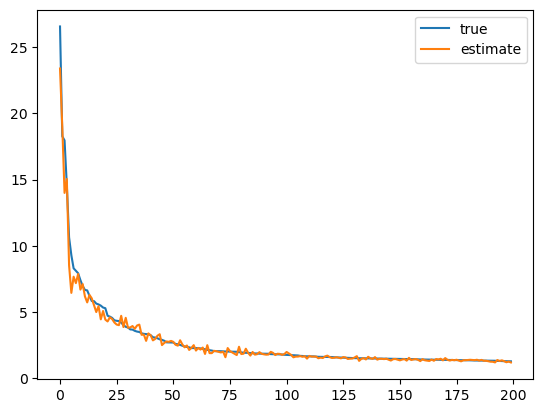

In [111]:
import matplotlib.pyplot as plt


# Sort the true_list in descending order
combined_lists = zip(true_dr, sample_density_ratio2)

# Sort the combined_lists based on the values of true_lst
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0],reverse=True)

# Separate the sorted lists back into true_lst and other_lst
sorted_true, sorted_estimate = zip(*sorted_combined_lists)

# Generate x-axis values
x_start =0
x_end = 200
x = range(x_end - x_start)

# Calculate the difference between the true and estimate lists
difference = [true - estimate for true, estimate in zip(sorted_true, sorted_estimate)]
print(la.norm(difference)**2/1000)
# plt.plot(x, true_list[x_start:x_end], label='true')
# plt.plot(x, sample_density_ratio2[x_start:x_end], label='estimate')
plt.plot(x, sorted_true[x_start:x_end], label='true')
plt.plot(x, sorted_estimate[x_start:x_end], label='estimate')
plt.legend()
plt.show()

In [61]:
# Calculate average loss of 2 estimate method
for i in range(1000):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)



KeyboardInterrupt: 

In [311]:
s = np.array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])
t = np.array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])
u = np.array([ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

# Simulation study

In [7]:
# verificaion by the p value
l = 3
count = 0
#calculate covariance matrix
probability= 0
for j in trange(200):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 1, Alpha_t = 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    # densratio_obj = densratio(D_t, D_s)
    # #calculate density ratio for each sample
    # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)
    # true_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 1, Alpha_t = 0)
    est_dr = v_dr[:2000] * xz_dr[:2000]
    reg = 1
    cov1 = generate_cov_matrix(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)
    # print(cov1)
    w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = True, density_ratio = est_dr, regr = reg)
    weight = la.eigh(cov1)[0]
    # print([w,statistic])
    p_value = 1-mchi.hbe(coeff=weight, x=statistic)
    # #p_value = monte_carlo_p_value(100000, cov1, l, statistic)
    # w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
    # p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
    probability = count/(j+1)


  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (400,) (2000,) 

In [37]:
probability

0.08

In [27]:
# Power enhancement
l = 5
count = 0
#calculate covariance matrix
probability= 0
for j in trange(200):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    reg=1
    
    true_dr = true_density_ratio(X_source[:2000], Z_source[:2000], V_source[:2000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    est_dr = v_dr[:2000] * xz_dr[:2000]
    
    WV, statistic, a, b, c, g = PCRtest_Powen(Y_source[:2000], X_source[:2000], Z_source[:2000], V_source[:2000], Y_target[:2000], X_target[:2000], Z_target[:2000], V_target[:2000], u, s, t, l, 20, true_dr, reg)
    cov = generate_cov_matrix_powen(a, b, c, g, l, 20, density_ratio = true_dr)
    weight = la.eigh(cov)[0]
    p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
    print(p_value)

    if p_value < 0.1:
        count += 1
    probability = count/(j+1)

  0%|          | 1/200 [00:04<14:18,  4.32s/it]

0.01612985856628457


  1%|          | 2/200 [00:08<14:09,  4.29s/it]

0.00017110323746560852


  2%|▏         | 3/200 [00:12<14:08,  4.31s/it]

1.6415635431088482e-05


  2%|▏         | 4/200 [00:17<14:10,  4.34s/it]

0.03732714269572346


  2%|▎         | 5/200 [00:21<14:06,  4.34s/it]

1.2202567756247618e-07


  3%|▎         | 6/200 [00:25<14:00,  4.33s/it]

0.010494790711144342


  4%|▎         | 7/200 [00:30<13:49,  4.30s/it]

0.266489794419144


  4%|▍         | 8/200 [00:34<13:47,  4.31s/it]

0.5853667133722258


  4%|▍         | 9/200 [00:38<13:42,  4.30s/it]

0.025496497621961378


  5%|▌         | 10/200 [00:43<13:40,  4.32s/it]

1.1128771237878254e-09


  6%|▌         | 11/200 [00:47<13:32,  4.30s/it]

0.0019244439437492433


  6%|▌         | 12/200 [00:51<13:28,  4.30s/it]

0.038430806682498986


  6%|▋         | 13/200 [00:55<13:21,  4.28s/it]

0.00037099251994621163


  7%|▋         | 14/200 [01:00<13:18,  4.29s/it]

0.2611410426748193


  8%|▊         | 15/200 [01:04<13:14,  4.29s/it]

0.289440492899824


  8%|▊         | 16/200 [01:08<13:04,  4.26s/it]

0.46845767838378916


  8%|▊         | 17/200 [01:13<13:00,  4.27s/it]

0.7310305404475037


  9%|▉         | 18/200 [01:17<12:57,  4.27s/it]

0.23417449910574373


 10%|▉         | 19/200 [01:21<12:49,  4.25s/it]

0.3909351583091142


 10%|█         | 20/200 [01:25<12:45,  4.25s/it]

0.00022738606041150522


 10%|█         | 21/200 [01:29<12:37,  4.23s/it]

0.03473552416261905


 11%|█         | 22/200 [01:34<12:36,  4.25s/it]

0.016589606037921034


 12%|█▏        | 23/200 [01:38<12:33,  4.26s/it]

0.0027846327502402124


 12%|█▏        | 24/200 [01:42<12:25,  4.23s/it]

0.00015914674467587542


 12%|█▎        | 25/200 [01:47<12:27,  4.27s/it]

0.15813494895917002


 13%|█▎        | 26/200 [01:51<12:21,  4.26s/it]

0.03390060695889807


 14%|█▎        | 27/200 [01:55<12:18,  4.27s/it]

0.41492390347032804


 14%|█▍        | 28/200 [01:59<12:15,  4.28s/it]

0.0342360320458488


 14%|█▍        | 29/200 [02:04<12:10,  4.27s/it]

0.30924678242159664


 15%|█▌        | 30/200 [02:08<12:03,  4.26s/it]

0.05640831458370732


 16%|█▌        | 31/200 [02:12<11:58,  4.25s/it]

6.015327540076498e-06


 16%|█▌        | 32/200 [02:16<11:57,  4.27s/it]

0.06360429432456327


 16%|█▋        | 33/200 [02:21<11:52,  4.27s/it]

0.021403159391347626


 17%|█▋        | 34/200 [02:25<11:48,  4.27s/it]

0.06574214524224364


 18%|█▊        | 35/200 [02:29<11:44,  4.27s/it]

0.19923789383317747


 18%|█▊        | 36/200 [02:34<11:41,  4.28s/it]

0.09986108221104906


 18%|█▊        | 37/200 [02:38<11:37,  4.28s/it]

0.000301557220502513


 19%|█▉        | 38/200 [02:42<11:33,  4.28s/it]

0.0003936531549276756


 20%|█▉        | 39/200 [02:46<11:31,  4.30s/it]

6.733042972384418e-06


 20%|██        | 40/200 [02:51<11:26,  4.29s/it]

0.0019275258989864819


 20%|██        | 41/200 [02:55<11:17,  4.26s/it]

0.02829013210687381


 21%|██        | 42/200 [02:59<11:13,  4.26s/it]

2.6988347352485675e-06


 22%|██▏       | 43/200 [03:03<11:05,  4.24s/it]

0.012981769852767111


 22%|██▏       | 44/200 [03:08<11:07,  4.28s/it]

9.01691805421656e-06


 22%|██▎       | 45/200 [03:12<11:01,  4.27s/it]

0.0005870942499720533


 23%|██▎       | 46/200 [03:16<10:53,  4.25s/it]

0.10546778647240118


 24%|██▎       | 47/200 [03:20<10:48,  4.24s/it]

0.03004955511455798


 24%|██▍       | 48/200 [03:25<10:47,  4.26s/it]

7.009330557639082e-06


 24%|██▍       | 49/200 [03:29<10:38,  4.23s/it]

0.15062183673184404


 25%|██▌       | 50/200 [03:33<10:32,  4.21s/it]

0.10592554290775058


 26%|██▌       | 51/200 [03:37<10:31,  4.24s/it]

0.22080416688011062


 26%|██▌       | 52/200 [03:42<10:27,  4.24s/it]

0.0007498042694711327


 26%|██▋       | 53/200 [03:46<10:26,  4.26s/it]

0.006868089424333035


 27%|██▋       | 54/200 [03:50<10:23,  4.27s/it]

0.060592736496563604


 28%|██▊       | 55/200 [03:54<10:17,  4.26s/it]

2.8006847492267894e-06


 28%|██▊       | 56/200 [03:59<10:10,  4.24s/it]

0.04293258786744736


 28%|██▊       | 57/200 [04:03<10:05,  4.23s/it]

0.0035748303185586527


 29%|██▉       | 58/200 [04:07<10:03,  4.25s/it]

0.00023480279363896628


 30%|██▉       | 59/200 [04:11<10:02,  4.27s/it]

5.293013027873883e-08


 30%|███       | 60/200 [04:16<09:54,  4.25s/it]

0.00012062808377799605


 30%|███       | 61/200 [04:20<09:50,  4.25s/it]

0.00032932715111599897


 31%|███       | 62/200 [04:24<09:47,  4.26s/it]

5.0240056559403e-10


 32%|███▏      | 63/200 [04:28<09:44,  4.27s/it]

0.004957468380039742


 32%|███▏      | 64/200 [04:33<09:40,  4.27s/it]

0.3397428257050048


 32%|███▎      | 65/200 [04:37<09:37,  4.28s/it]

0.011561520265675695


 33%|███▎      | 66/200 [04:42<09:43,  4.35s/it]

0.11464386321904563


 34%|███▎      | 67/200 [04:46<09:39,  4.36s/it]

0.7968502093028718


 34%|███▍      | 68/200 [04:50<09:35,  4.36s/it]

0.36725192356845304


 34%|███▍      | 69/200 [04:55<09:25,  4.32s/it]

0.0009465496163892917


 35%|███▌      | 70/200 [04:59<09:20,  4.31s/it]

0.00020892464328337024


 36%|███▌      | 71/200 [05:03<09:16,  4.32s/it]

3.380784578954632e-07


 36%|███▌      | 72/200 [05:07<09:12,  4.32s/it]

0.012111027702128574


 36%|███▋      | 73/200 [05:12<09:06,  4.30s/it]

0.00194134344208019


 37%|███▋      | 74/200 [05:16<09:07,  4.34s/it]

0.06703747824348893


 38%|███▊      | 75/200 [05:20<09:02,  4.34s/it]

0.00010950712270940688


 38%|███▊      | 76/200 [05:25<08:55,  4.32s/it]

0.22970182886813262


 38%|███▊      | 77/200 [05:29<08:53,  4.34s/it]

0.22812341741494602


 39%|███▉      | 78/200 [05:33<08:48,  4.33s/it]

0.010092056841911168


 40%|███▉      | 79/200 [05:38<08:44,  4.34s/it]

0.0017150334764597375


 40%|████      | 80/200 [05:42<08:37,  4.31s/it]

0.0015719774486816496


 40%|████      | 81/200 [05:46<08:31,  4.30s/it]

0.06429087115259735


 41%|████      | 82/200 [05:51<08:26,  4.29s/it]

1.0664721616926442e-06


 42%|████▏     | 83/200 [05:55<08:19,  4.27s/it]

0.47780701455469177


 42%|████▏     | 84/200 [05:59<08:15,  4.27s/it]

0.24054882229396535


 42%|████▎     | 85/200 [06:03<08:10,  4.26s/it]

0.017857271911815742


 43%|████▎     | 86/200 [06:08<08:02,  4.24s/it]

0.41956060581063215


 44%|████▎     | 87/200 [06:12<07:56,  4.22s/it]

0.0003252522757986043


 44%|████▍     | 88/200 [06:16<07:53,  4.22s/it]

8.470871714960637e-06


 44%|████▍     | 89/200 [06:20<07:56,  4.29s/it]

0.2417769439234575


 45%|████▌     | 90/200 [06:25<07:51,  4.29s/it]

0.6629169925268615


 46%|████▌     | 91/200 [06:29<07:51,  4.32s/it]

4.036092779102773e-06


 46%|████▌     | 92/200 [06:34<07:51,  4.36s/it]

0.018791676693148296


 46%|████▋     | 93/200 [06:38<07:47,  4.37s/it]

0.009840600075340378


 47%|████▋     | 94/200 [06:42<07:42,  4.36s/it]

0.04066261136029026


 48%|████▊     | 95/200 [06:47<07:37,  4.35s/it]

0.0006981030416721712


 48%|████▊     | 96/200 [06:51<07:32,  4.35s/it]

0.40696281499127906


 48%|████▊     | 97/200 [06:55<07:22,  4.30s/it]

0.0007566619288560394


 49%|████▉     | 98/200 [07:00<07:22,  4.34s/it]

0.18787563042701572


 50%|████▉     | 99/200 [07:04<07:20,  4.36s/it]

0.02892824093728874


 50%|█████     | 100/200 [07:08<07:14,  4.34s/it]

4.324486846285502e-06


 50%|█████     | 101/200 [07:12<07:06,  4.31s/it]

0.06459993647696505


 51%|█████     | 102/200 [07:17<06:59,  4.29s/it]

6.499720187536084e-05


 52%|█████▏    | 103/200 [07:21<06:53,  4.27s/it]

0.001059764640133909


 52%|█████▏    | 104/200 [07:25<06:48,  4.26s/it]

0.00022655685971628703


 52%|█████▎    | 105/200 [07:30<06:46,  4.28s/it]

6.5576851911997025e-06


 53%|█████▎    | 106/200 [07:34<06:40,  4.26s/it]

0.007967898639938187


 54%|█████▎    | 107/200 [07:38<06:39,  4.30s/it]

0.0031287439953773255


 54%|█████▍    | 108/200 [07:42<06:32,  4.27s/it]

0.0004132560458482981


 55%|█████▍    | 109/200 [07:47<06:31,  4.31s/it]

0.0020237721612481607


 55%|█████▌    | 110/200 [07:51<06:23,  4.27s/it]

0.22390968259740385


 56%|█████▌    | 111/200 [07:55<06:18,  4.25s/it]

0.46594182732571165


 56%|█████▌    | 112/200 [07:59<06:15,  4.27s/it]

0.0010191771685638118


 56%|█████▋    | 113/200 [08:04<06:11,  4.27s/it]

0.09187214987445158


 57%|█████▋    | 114/200 [08:08<06:06,  4.26s/it]

0.00019563167726499575


 57%|█████▊    | 115/200 [08:12<06:02,  4.26s/it]

0.0036342814089067588


 58%|█████▊    | 116/200 [08:16<05:56,  4.24s/it]

0.10121047710326592


 58%|█████▊    | 117/200 [08:21<05:53,  4.26s/it]

5.7999194114088937e-08


 59%|█████▉    | 118/200 [08:25<05:51,  4.29s/it]

0.04184799313684018


 60%|█████▉    | 119/200 [08:30<05:55,  4.39s/it]

0.0009845561347232579


 60%|██████    | 120/200 [08:34<05:48,  4.36s/it]

0.0002801369666619591


 60%|██████    | 121/200 [08:38<05:46,  4.39s/it]

0.04214999563248756


 61%|██████    | 122/200 [08:43<05:42,  4.40s/it]

0.08123643819621884


 62%|██████▏   | 123/200 [08:47<05:33,  4.34s/it]

0.3248285348792471


 62%|██████▏   | 124/200 [08:51<05:29,  4.34s/it]

9.469939864326093e-05


 62%|██████▎   | 125/200 [08:56<05:23,  4.31s/it]

0.14506060410919497


 63%|██████▎   | 126/200 [09:00<05:17,  4.29s/it]

0.06082583213195514


 64%|██████▎   | 127/200 [09:04<05:14,  4.30s/it]

0.2207791898394491


 64%|██████▍   | 128/200 [09:09<05:13,  4.35s/it]

0.31840391670281787


 64%|██████▍   | 129/200 [09:13<05:05,  4.30s/it]

0.09215557402764962


 65%|██████▌   | 130/200 [09:17<05:00,  4.30s/it]

0.74002230261072


 66%|██████▌   | 131/200 [09:21<04:55,  4.29s/it]

5.474145642714312e-05


 66%|██████▌   | 132/200 [09:26<04:48,  4.25s/it]

0.00028766637142418894


 66%|██████▋   | 133/200 [09:30<04:50,  4.33s/it]

0.7426433977932313


 67%|██████▋   | 134/200 [09:34<04:45,  4.32s/it]

0.02486664941012451


 68%|██████▊   | 135/200 [09:39<04:42,  4.34s/it]

0.0005286124970013129


 68%|██████▊   | 136/200 [09:43<04:37,  4.33s/it]

0.00695743955163608


 68%|██████▊   | 137/200 [09:47<04:33,  4.34s/it]

0.011612319237388258


 69%|██████▉   | 138/200 [09:52<04:27,  4.31s/it]

2.398570364547936e-08


 70%|██████▉   | 139/200 [09:56<04:22,  4.30s/it]

0.0031042390374503848


 70%|███████   | 140/200 [10:00<04:18,  4.30s/it]

0.006380264883440234


 70%|███████   | 141/200 [10:05<04:16,  4.34s/it]

0.008866534033643125


 71%|███████   | 142/200 [10:09<04:10,  4.32s/it]

0.03495083848682934


 72%|███████▏  | 143/200 [10:13<04:04,  4.29s/it]

0.0036723455136730143


 72%|███████▏  | 144/200 [10:17<04:01,  4.31s/it]

0.00015344147661522367


 72%|███████▎  | 145/200 [10:22<03:55,  4.28s/it]

6.925810205704597e-05


 73%|███████▎  | 146/200 [10:26<03:51,  4.29s/it]

0.23613799974005978


 74%|███████▎  | 147/200 [10:30<03:49,  4.32s/it]

0.0005343304682976502


 74%|███████▍  | 148/200 [10:35<03:45,  4.34s/it]

0.2710313209361698


 74%|███████▍  | 149/200 [10:39<03:40,  4.33s/it]

0.014530927146516381


 75%|███████▌  | 150/200 [10:43<03:34,  4.29s/it]

0.19112888026362995


 76%|███████▌  | 151/200 [10:47<03:28,  4.26s/it]

0.1749926317223105


 76%|███████▌  | 152/200 [10:52<03:23,  4.23s/it]

0.007138060933290724


 76%|███████▋  | 153/200 [10:56<03:17,  4.20s/it]

0.6408767115033491


 77%|███████▋  | 154/200 [11:00<03:12,  4.18s/it]

1.1592006212146622e-05


 78%|███████▊  | 155/200 [11:04<03:07,  4.16s/it]

0.0020436550389959507


 78%|███████▊  | 156/200 [11:08<03:03,  4.17s/it]

0.2883899037973655


 78%|███████▊  | 157/200 [11:12<02:58,  4.15s/it]

0.010964120596617999


 79%|███████▉  | 158/200 [11:16<02:54,  4.15s/it]

0.00021342173558758226


 80%|███████▉  | 159/200 [11:21<02:50,  4.15s/it]

0.29972030469550537


 80%|████████  | 160/200 [11:25<02:46,  4.16s/it]

3.803266157542673e-05


 80%|████████  | 161/200 [11:29<02:41,  4.14s/it]

0.0006746166069885318


 81%|████████  | 162/200 [11:33<02:36,  4.13s/it]

0.001192460503478654


 82%|████████▏ | 163/200 [11:37<02:33,  4.14s/it]

0.2454633150633374


 82%|████████▏ | 164/200 [11:41<02:29,  4.14s/it]

0.002164224268266346


 82%|████████▎ | 165/200 [11:45<02:25,  4.15s/it]

0.013168767826127192


 83%|████████▎ | 166/200 [11:50<02:20,  4.14s/it]

0.0002716177145852816


 84%|████████▎ | 167/200 [11:54<02:16,  4.14s/it]

0.005278216416427228


 84%|████████▍ | 168/200 [11:58<02:12,  4.14s/it]

0.001986697899704404


 84%|████████▍ | 169/200 [12:02<02:08,  4.14s/it]

5.209335525835357e-06


 85%|████████▌ | 170/200 [12:06<02:03,  4.13s/it]

0.7824557887042309


 86%|████████▌ | 171/200 [12:10<02:00,  4.14s/it]

0.000168944833629614


 86%|████████▌ | 172/200 [12:14<01:55,  4.14s/it]

0.0013207014139425821


 86%|████████▋ | 173/200 [12:19<01:51,  4.14s/it]

0.0021396704913487774


 87%|████████▋ | 174/200 [12:23<01:47,  4.13s/it]

0.08459509397599829


 88%|████████▊ | 175/200 [12:27<01:43,  4.15s/it]

3.931893860520397e-05


 88%|████████▊ | 176/200 [12:31<01:39,  4.15s/it]

2.2002567345857926e-07


 88%|████████▊ | 177/200 [12:35<01:35,  4.15s/it]

0.00025033532848084405


 89%|████████▉ | 178/200 [12:39<01:31,  4.14s/it]

0.0005408503588753


 90%|████████▉ | 179/200 [12:43<01:27,  4.15s/it]

5.3417637302377585e-06


 90%|█████████ | 180/200 [12:48<01:22,  4.14s/it]

5.0135973886700214e-05


 90%|█████████ | 181/200 [12:52<01:18,  4.14s/it]

9.850442030157058e-05


 91%|█████████ | 182/200 [12:56<01:14,  4.13s/it]

0.03878099567748872


 92%|█████████▏| 183/200 [13:00<01:10,  4.17s/it]

3.0350248103605537e-06


 92%|█████████▏| 184/200 [13:04<01:06,  4.17s/it]

2.2824761469197874e-05


 92%|█████████▎| 185/200 [13:08<01:02,  4.16s/it]

0.0003567649533202655


 93%|█████████▎| 186/200 [13:13<00:58,  4.16s/it]

0.000858774274196672


 94%|█████████▎| 187/200 [13:17<00:54,  4.16s/it]

0.001737131760028876


 94%|█████████▍| 188/200 [13:21<00:49,  4.15s/it]

0.00043680121142630757


 94%|█████████▍| 189/200 [13:25<00:45,  4.15s/it]

0.0006024734211712568


 95%|█████████▌| 190/200 [13:29<00:41,  4.16s/it]

0.0075923194435346675


 96%|█████████▌| 191/200 [13:33<00:37,  4.16s/it]

0.009425926148228458


 96%|█████████▌| 192/200 [13:38<00:33,  4.18s/it]

0.0008155793189974503


 96%|█████████▋| 193/200 [13:42<00:29,  4.17s/it]

0.009631634050868199


 97%|█████████▋| 194/200 [13:46<00:25,  4.17s/it]

0.06068013716251952


 98%|█████████▊| 195/200 [13:50<00:20,  4.16s/it]

0.3150136326283637


 98%|█████████▊| 196/200 [13:54<00:16,  4.15s/it]

0.061741341536992955


 98%|█████████▊| 197/200 [13:58<00:12,  4.15s/it]

0.012796335803043402


 99%|█████████▉| 198/200 [14:02<00:08,  4.15s/it]

4.428169933845538e-06


100%|█████████▉| 199/200 [14:07<00:04,  4.16s/it]

0.1387114059566812


100%|██████████| 200/200 [14:11<00:00,  4.26s/it]

0.00033912844483974247


## Benchmark for no covariate shift

In [35]:
# verificaion by the p value
prob_lst = []
for l in [2,5,10,15,20,30]:

    count = 0
    #calculate covariance matrix
    probability= 0
    for j in trange(200):
        #generate data
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 1, Alpha_t = 0)

        # calculate density ratio
        D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
        D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

        v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
        xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
        # densratio_obj = densratio(D_t, D_s)
        # #calculate density ratio for each sample
        # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)
        true_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 1, Alpha_t = 0)
        est_dr = v_dr[:2000] * xz_dr[:2000]

        # cov1 = generate_cov_matrix(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)
        # # print(cov1)
        # w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
        # weight = la.eigh(cov1)[0]
        # print([w,statistic])
        # p_value = 1-mchi.lpb4(coeff=weight, x=statistic)
        # #p_value = monte_carlo_p_value(100000, cov1, l, statistic)
        w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
        p_value = chi_squared_p_value(statistic, l-1)
        #print(p_value)
        if p_value < 0.1:
            count += 1
        probability = count/(j+1)
    prob_lst.append(probability)

100%|██████████| 200/200 [24:14<00:00,  7.27s/it]


## Benchmark method: Resampling from source


In [66]:
from tqdm import tqdm
def resample(Y_source, X_source, Z_source, V_source, M, density_ratio = None):
    n = Y_source.shape[0]
    Y_, X_, Z_, V_ = [], [], [], []
    for i in range(n):
        value = density_ratio[i]
        u = np.random.random()
        if value >= u * M:
            Y_.append(Y_source[i])
            X_.append(X_source[i])
            Z_.append(Z_source[i])
            V_.append(V_source[i])
    Y_, X_, Z_, V_ = np.array(Y_) , np.array(X_), np.array(Z_), np.array(V_)
    return Y_, X_, Z_, V_

def resample_DR(num_samples, density_ratio, rate = lambda n: n**0.5, replacement='NO-REPL-gibbs', m=None):
        """
        Resampling function that returns a weighted resample of X
        Return the index of the resampled data
        """

        # Compute sample and resample size
        n = num_samples
        m = int(rate(num_samples)) if m is None else m

        # Draw weights
        w = np.array(density_ratio[:num_samples]).ravel()
        w /= w.sum()
        
        # Resample with modified replacement scheme:
        # Sample w replace, but reject if non-distinct
        if replacement == "REPL-reject":
            idx = np.random.choice(n, size=m, p=w, replace=True)
            count = 0
            while count < 100 and (len(np.unique(idx)) != len(idx)):
                count += 1
                idx = np.random.choice(n, size=m, p=w, replace=True)

            print(f"Rejections: {count}")
            raise ValueError("Unable to draw sample from REPL rejection sampler")

        elif replacement == "NO-REPL-gibbs":
            # Initialize space
            space = np.arange(n)
            # Initialize Gibbs sampler in NO-REPL distribution and shuffle to mimick dist
            idx = np.random.choice(space, size=m, p=w, replace=False)
            np.random.shuffle(idx)

            # Loop, sampling from conditional
            for _ in range(10):
                for j, i in (enumerate(idx)):
                    retain = np.delete(idx, j)
                    vacant = np.setdiff1d(space, retain)
                    idx[j] = np.random.choice(vacant, 1, p=w[vacant]/w[vacant].sum())

        elif replacement == "NO-REPL-reject":
            # Denominator for rejection sampler is smallest weights
            m_smallest = np.cumsum(w[np.argsort(w)][:(m-1)])

            # Sample from proposal, and compute bound p/Mq
            count = 0
            idx = np.random.choice(n, size=m, p=w, replace=False)
            bound = np.prod(1 - np.cumsum(w[idx])[:-1])/np.prod(1 - m_smallest)

            while ((np.random.uniform() > bound) and count < 100):
                count += 1
                idx = np.random.choice(n, size=m, p=w, replace=False)
                bound = np.prod(1 - np.cumsum(w[idx])[:-1])/np.prod(1 - m_smallest)

            if count == 100:
                raise ValueError("Unable to draw sample from NO-REPL rejection sampler")
                

        # If nothing else, just sample with or without replacement
        else:
            idx = np.random.choice(n, size=m, p=w, replace=replacement)


        return idx
    

def benchmark(test_n, alpha, L, K):
    sample_density_ratio2=1
    count = 0
    beta = 0.2
    chi_list_1=[3.841, 5.991, 7.815, 9.488, 11.07]
    chi_list_2=[2.706, 4.605, 6.251, 7.779, 9.236]
    p_list=[]
    sample_num=[]
    eff_size=[]
    Las = LassoCV()
    for i in trange(test_n):
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, alpha, beta)
        W = np.hstack((X_source, Z_source))
        reg = Las.fit(W, Y_source.ravel())

        Y_, X_, Z_, V_ , size = resample(Y_source, X_source, Z_source, V_source, Y_target, X_target, V_target, Z_target)
        xp, p_value = PCRtest(Y_, X_, Z_, V_, u, s, t, L, K, covariate_shift = False, density_ratio = 1, regr = reg)
        #print(xp)
        if p_value > chi_list_1[L-2]:
            count += 1
        p_list.append(p_value)
        sample_num.append(Y_.size)
        eff_size.append(size)

    print("count = ", count, "score =",  count/test_n)
    print(p_list)
    #print(sample_num)
    #print(np.array(eff_size)*np.array(sample_num))
    return count, count/test_n



In [67]:
ns,nt, p,q = 2000,2000, 5, 50
n_labeled = 1000
s = np.array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])
t = np.array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])
u = np.array([ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

In [10]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2)
# calculate density ratio
D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

true_dr = true_density_ratio(X_source[:5000], Z_source[:5000], V_source[:5000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)

In [11]:
true_dr.ravel()

array([0.62454695, 1.02426892, 1.21447491, ..., 0.05938951, 0.76308974,
       0.66330679])

In [12]:
index = resample_DR(1000, true_dr)

In [13]:
index

array([669, 162, 722, 557, 204, 868, 278, 637, 235, 863, 123, 337,  68,
        53, 237, 624, 845, 904, 196, 833, 192, 306, 777, 265, 668, 888,
       535, 984,  14,  58, 286])

In [70]:
# Resample with Dinstinct replacement resampling method

l = 3

count = 0

for i in trange(100):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2,effect=0)
    # calculate density ratio
    
    true_dr = true_density_ratio(X_source[:5000], Z_source[:5000], V_source[:5000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    print(max(true_dr))
    reg = 1
    index = resample_DR(1000, true_dr)
    Y_, X_, Z_, V_ = Y_source[index], X_source[index], Z_source[index], V_source[index]
    _,statistic = PCRtest(Y_, X_, Z_, V_, u, s, t, L = l, K = 20, covariate_shift = False, density_ratio = None, regr = reg)
    p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
probability = count/100

  1%|          | 1/100 [00:00<00:45,  2.20it/s]

[23.26644367]
0.039723733386441085


  2%|▏         | 2/100 [00:00<00:46,  2.12it/s]

[43.72664644]
0.4464393987758163


  3%|▎         | 3/100 [00:01<00:46,  2.09it/s]

[16.33444201]
0.016626221963982668


  4%|▍         | 4/100 [00:01<00:46,  2.06it/s]

[13.46115948]
0.5417756864712342


  5%|▌         | 5/100 [00:02<00:45,  2.09it/s]

[12.59449202]
0.36787944117144233


  6%|▌         | 6/100 [00:02<00:44,  2.11it/s]

[90.22175782]
0.7978725136602237


  7%|▋         | 7/100 [00:03<00:44,  2.10it/s]

[17.77075777]
0.6574708577608569


  8%|▊         | 8/100 [00:03<00:43,  2.12it/s]

[22.39892168]
0.24979947719340545


  9%|▉         | 9/100 [00:04<00:42,  2.15it/s]

[29.31450592]
0.24979947719340545


 10%|█         | 10/100 [00:04<00:42,  2.11it/s]

[42.55762666]
0.5417756864712342


 11%|█         | 11/100 [00:05<00:41,  2.14it/s]

[14.62224425]
0.00766594304250845


 12%|█▏        | 12/100 [00:05<00:41,  2.14it/s]

[68.20344773]
0.029714235677790413


 13%|█▎        | 13/100 [00:06<00:41,  2.08it/s]

[45.74030776]
0.186855562273189


 14%|█▍        | 14/100 [00:06<00:40,  2.10it/s]

[22.79942137]
0.08615451547953645


 15%|█▌        | 15/100 [00:07<00:39,  2.13it/s]

[17.74653135]
0.3031436822281285


 16%|█▌        | 16/100 [00:07<00:39,  2.13it/s]

[40.28045014]
0.07820770578978964


 17%|█▋        | 17/100 [00:08<00:39,  2.13it/s]

[18.34692255]
0.8789456120040122


 18%|█▊        | 18/100 [00:08<00:38,  2.13it/s]

[20.07312664]
0.039723733386441085


 19%|█▉        | 19/100 [00:08<00:37,  2.16it/s]

[24.63008031]
0.7978725136602237


 20%|██        | 20/100 [00:09<00:37,  2.16it/s]

[27.58522271]
0.7978725136602237


 21%|██        | 21/100 [00:09<00:36,  2.14it/s]

[31.78795275]
0.07820770578978964


 22%|██▏       | 22/100 [00:10<00:36,  2.13it/s]

[23.73105816]
0.59682637785056


 23%|██▎       | 23/100 [00:10<00:35,  2.14it/s]

[16.99186359]
0.01128962668063005


 24%|██▍       | 24/100 [00:11<00:35,  2.13it/s]

[68.80813948]
0.657470857760857


 25%|██▌       | 25/100 [00:11<00:36,  2.05it/s]

[21.36483623]
0.05310501711260529


 26%|██▌       | 26/100 [00:12<00:36,  2.03it/s]

[15.97211786]
0.8789456120040122


 27%|██▋       | 27/100 [00:12<00:36,  2.03it/s]

[46.39193853]
0.0007514180621656097


 28%|██▊       | 28/100 [00:13<00:34,  2.09it/s]

[29.70257912]
0.36787944117144233


 29%|██▉       | 29/100 [00:13<00:34,  2.07it/s]

[25.16112552]
0.7978725136602237


 30%|███       | 30/100 [00:14<00:33,  2.11it/s]

[29.73300355]
0.08615451547953645


 31%|███       | 31/100 [00:14<00:33,  2.09it/s]

[13.4038757]
0.20584225390235988


 32%|███▏      | 32/100 [00:15<00:32,  2.11it/s]

[15.4286471]
0.186855562273189


 33%|███▎      | 33/100 [00:15<00:31,  2.12it/s]

[36.63701882]
0.8789456120040122


 34%|███▍      | 34/100 [00:16<00:31,  2.10it/s]

[26.64577782]
0.12687966910542814


 35%|███▌      | 35/100 [00:16<00:30,  2.11it/s]

[63.97169936]
0.07820770578978964


 36%|███▌      | 36/100 [00:17<00:32,  1.94it/s]

[27.13570889]
0.36787944117144233


 37%|███▋      | 37/100 [00:17<00:31,  1.98it/s]

[36.15138066]
0.036059654404263175


 38%|███▊      | 38/100 [00:18<00:30,  2.02it/s]

[40.56860607]
0.5417756864712342


 39%|███▉      | 39/100 [00:18<00:29,  2.09it/s]

[15.58271981]
0.59682637785056


 40%|████      | 40/100 [00:19<00:29,  2.06it/s]

[12.46255975]
0.8789456120040122


 41%|████      | 41/100 [00:19<00:27,  2.12it/s]

[42.08910321]
0.6574708577608569


 42%|████▏     | 42/100 [00:20<00:27,  2.09it/s]

[15.52730447]
0.09490881317327604


 43%|████▎     | 43/100 [00:20<00:26,  2.13it/s]

[45.99211082]
0.7978725136602237


 44%|████▍     | 44/100 [00:20<00:26,  2.11it/s]

[14.24751125]
0.7978725136602237


 45%|████▌     | 45/100 [00:21<00:25,  2.12it/s]

[15.74912282]
0.36787944117144233


 46%|████▌     | 46/100 [00:21<00:25,  2.14it/s]

[17.81851454]
0.36787944117144233


 47%|████▋     | 47/100 [00:22<00:25,  2.09it/s]

[28.84324591]
0.07820770578978964


 48%|████▊     | 48/100 [00:22<00:24,  2.09it/s]

[18.37893597]
0.008444891738625393


 49%|████▉     | 49/100 [00:23<00:24,  2.05it/s]

[12.3938456]
0.036059654404263175


 50%|█████     | 50/100 [00:23<00:25,  1.96it/s]

[20.85266823]
0.4052602577832697


 51%|█████     | 51/100 [00:24<00:25,  1.93it/s]

[10.56879522]
0.186855562273189


 52%|█████▏    | 52/100 [00:25<00:25,  1.89it/s]

[12.77362493]
0.4464393987758163


 53%|█████▎    | 53/100 [00:25<00:25,  1.81it/s]

[18.01008444]
0.0035345782618738664


 54%|█████▍    | 54/100 [00:26<00:25,  1.82it/s]

[137.72347623]
0.4052602577832697


 55%|█████▌    | 55/100 [00:26<00:25,  1.75it/s]

[30.08161408]
0.186855562273189


 56%|█████▌    | 56/100 [00:27<00:25,  1.73it/s]

[15.4694752]
0.186855562273189


 57%|█████▋    | 57/100 [00:27<00:24,  1.78it/s]

[55.78825532]
0.036059654404263175


 58%|█████▊    | 58/100 [00:28<00:22,  1.86it/s]

[10.19411776]
0.9682566771439105


 59%|█████▉    | 59/100 [00:28<00:20,  1.95it/s]

[54.73358572]
0.036059654404263175


 60%|██████    | 60/100 [00:29<00:20,  1.98it/s]

[34.67948187]
0.5417756864712342


 61%|██████    | 61/100 [00:29<00:18,  2.07it/s]

[14.29098029]
0.5417756864712342


 62%|██████▏   | 62/100 [00:30<00:18,  2.09it/s]

[15.50743726]
0.5417756864712342


 63%|██████▎   | 63/100 [00:30<00:17,  2.10it/s]

[27.1942973]
0.1397721145965286


 64%|██████▍   | 64/100 [00:31<00:17,  2.05it/s]

[11.20916121]
0.8789456120040122


 65%|██████▌   | 65/100 [00:31<00:16,  2.07it/s]

[38.68575942]
0.20584225390235988


 66%|██████▌   | 66/100 [00:32<00:16,  2.05it/s]

[21.50324607]
0.20584225390235988


 67%|██████▋   | 67/100 [00:32<00:16,  2.02it/s]

[11.80961618]
0.7978725136602237


 68%|██████▊   | 68/100 [00:33<00:15,  2.04it/s]

[42.24262346]
0.4052602577832697


 69%|██████▉   | 69/100 [00:33<00:14,  2.08it/s]

[18.72639904]
0.5417756864712342


 70%|███████   | 70/100 [00:34<00:14,  2.11it/s]

[10.11493553]
0.3031436822281285


 71%|███████   | 71/100 [00:34<00:13,  2.08it/s]

[15.84157557]
0.4464393987758163


 72%|███████▏  | 72/100 [00:35<00:13,  2.06it/s]

[52.41381418]
0.05310501711260529


 73%|███████▎  | 73/100 [00:35<00:12,  2.11it/s]

[31.50330295]
0.02697342314238982


 74%|███████▍  | 74/100 [00:36<00:12,  2.13it/s]

[73.46523116]
0.8789456120040122


 75%|███████▌  | 75/100 [00:36<00:11,  2.15it/s]

[46.43093311]
0.04376012527647777


 76%|███████▌  | 76/100 [00:36<00:11,  2.08it/s]

[14.43610367]
0.8789456120040122


 77%|███████▋  | 77/100 [00:37<00:11,  2.07it/s]

[22.08551719]
0.11517641039325577


 78%|███████▊  | 78/100 [00:37<00:10,  2.11it/s]

[19.72729759]
0.186855562273189


 79%|███████▉  | 79/100 [00:38<00:10,  2.02it/s]

[20.74710027]
0.036059654404263175


 80%|████████  | 80/100 [00:38<00:09,  2.03it/s]

[15.61468648]
0.4052602577832697


 81%|████████  | 81/100 [00:39<00:09,  2.05it/s]

[31.18878515]
0.00766594304250845


 82%|████████▏ | 82/100 [00:39<00:08,  2.05it/s]

[17.71270322]
0.7978725136602237


 83%|████████▎ | 83/100 [00:40<00:08,  2.11it/s]

[14.48319356]
0.6574708577608569


 84%|████████▍ | 84/100 [00:40<00:07,  2.13it/s]

[31.00512015]
0.1397721145965286


 85%|████████▌ | 85/100 [00:41<00:07,  2.14it/s]

[12.40655034]
0.09490881317327604


 86%|████████▌ | 86/100 [00:41<00:06,  2.15it/s]

[11.81593814]
0.36787944117144233


 87%|████████▋ | 87/100 [00:42<00:06,  2.11it/s]

[29.20131344]
0.013700505066699398


 88%|████████▊ | 88/100 [00:42<00:05,  2.07it/s]

[11.40785755]
0.0531050171126054


 89%|████████▉ | 89/100 [00:43<00:05,  2.04it/s]

[22.05645388]
0.24979947719340545


 90%|█████████ | 90/100 [00:43<00:04,  2.05it/s]

[33.7152419]
0.05310501711260529


 91%|█████████ | 91/100 [00:44<00:04,  2.08it/s]

[13.81959535]
0.036059654404263175


 92%|█████████▏| 92/100 [00:44<00:04,  1.91it/s]

[49.96826971]
0.07820770578978964


 93%|█████████▎| 93/100 [00:45<00:03,  1.96it/s]

[20.2460118]
0.8789456120040122


 94%|█████████▍| 94/100 [00:45<00:03,  1.97it/s]

[38.69055206]
0.4052602577832697


 95%|█████████▌| 95/100 [00:46<00:02,  2.01it/s]

[78.30425787]
0.1397721145965286


 96%|█████████▌| 96/100 [00:46<00:01,  2.04it/s]

[14.5824875]
0.24979947719340545


 97%|█████████▋| 97/100 [00:47<00:01,  2.07it/s]

[16.55105214]
0.24979947719340545


 98%|█████████▊| 98/100 [00:47<00:00,  2.10it/s]

[16.20289797]
0.029714235677790413


 99%|█████████▉| 99/100 [00:48<00:00,  2.09it/s]

[11.56012867]
0.8789456120040122


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

[14.3511009]
0.9682566771439105


In [71]:
probability

0.33

In [52]:
# Resample with a uniformly bounded density ratio

l = 20

count = 0

for i in trange(200):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s = 0, Alpha_t = 2)
    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    true_dr = true_density_ratio(X_source[:5000], Z_source[:5000], V_source[:5000],s,t,p,q,Alpha_s = 0, Alpha_t = 2)
    Max = np.max(true_dr)
    Min = np.min(true_dr)

    
    # sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)

    reg = 1
    Y_, X_, Z_, V_ = resample(Y_source[:5000], X_source[:5000], Z_source[:5000], V_source[:5000], M =Max, density_ratio=true_dr)
    _,statistic = PCRtest(Y_, X_, Z_, V_, u, s, t, L = l, K = 20, covariate_shift = False, density_ratio = None, regr = reg)
    p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
probability = count/200

  0%|          | 1/200 [00:01<04:42,  1.42s/it]

0.23594642392730525


  1%|          | 2/200 [00:02<04:23,  1.33s/it]

0.2842562586689543


  2%|▏         | 3/200 [00:03<04:15,  1.30s/it]

0.16643334427146916


  2%|▏         | 4/200 [00:05<04:01,  1.23s/it]

0.06956187048195461


  2%|▎         | 5/200 [00:06<04:10,  1.28s/it]

0.026537828746792336


  3%|▎         | 6/200 [00:07<04:12,  1.30s/it]

0.7905631566364135


  4%|▎         | 7/200 [00:08<04:00,  1.24s/it]

0.12302182575282239


  4%|▍         | 8/200 [00:10<04:00,  1.25s/it]

0.9267287560963762


  4%|▍         | 9/200 [00:11<03:53,  1.22s/it]

0.5323538111859532


  5%|▌         | 10/200 [00:12<03:55,  1.24s/it]

0.6868495652678883


  6%|▌         | 11/200 [00:13<03:58,  1.26s/it]

0.3840302785619858


  6%|▌         | 12/200 [00:15<03:53,  1.24s/it]

0.8566553233339844


  6%|▋         | 13/200 [00:16<03:46,  1.21s/it]

0.987709662920052


  7%|▋         | 14/200 [00:17<03:43,  1.20s/it]

0.15757154297703235


  8%|▊         | 15/200 [00:18<03:38,  1.18s/it]

0.12665613936291065


  8%|▊         | 16/200 [00:19<03:31,  1.15s/it]

0.560857539478349


  8%|▊         | 17/200 [00:20<03:33,  1.17s/it]

0.20533330214780698


  9%|▉         | 18/200 [00:22<03:33,  1.18s/it]

0.560857539478349


 10%|▉         | 19/200 [00:23<03:35,  1.19s/it]

0.6324414509404743


 10%|█         | 20/200 [00:24<03:49,  1.28s/it]

0.6801467340878377


 10%|█         | 20/200 [00:25<03:52,  1.29s/it]


KeyboardInterrupt: 

In [ ]:
probability

# Multiple testing

In [87]:
import numpy as np

# 定义矩阵的维度和列数
p = 5  # 维度
k = 200  # 列数

# 生成u_matrix，每列都是从N(0, 1, p)中随机采样的值
u_matrix = np.random.normal(0, 1, (p, k))



In [135]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate_multiple(ns,nt, p,q, s, t, u_matrix, Alpha_s = np.zeros(200),Alpha_t = np.concatenate((np.ones(100), np.zeros(100))))

In [140]:
X_source[1].shape

(200,)

In [250]:
# Carry out multiple testing
import numpy as np


def multiple_test(u_mat, l, K):
    n_labeled = 1000
    
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = \
    generate_multiple(ns,nt, p,q, s, t, u_matrix, Alpha_s = np.zeros(200),Alpha_t = np.concatenate((np.zeros(150), 2*np.ones(50))))
    
    # geerate a list to store the p-values
    p_value_lst = []
    
    # Do testing for each X, since they are independent, we just condition on Z
    for i in range(X_source.shape[1]):
        
        new_X_s, new_X_t = X_source[:,i].reshape(-1,1), X_target[:,i].reshape(-1,1)
        
        # Should consider all X and Z when estimating conditional model of V
        v_dr = v_true_ratio_multiple(X_source, Z_source, V_source, s,t,p,q,Alpha_s = np.zeros(200),Alpha_t = np.concatenate((np.zeros(150), 2*np.ones(50))))[:1000]
        xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)[:1000].reshape(-1,1)
        # print(v_dr.shape)
        # print(xz_dr.shape)
        est_dr = v_dr * xz_dr
        reg=1
    
        # true_dr = true_density_ratio(new_X[:n_labeled], new_Z[:n_labeled], new_V[:n_labeled],s,t,p,q,Alpha_s = 1, Alpha_t = 0)
        u = u_mat[:,i]
        
        cov1 = generate_cov_matrix(Y_source[:n_labeled], new_X_s[:n_labeled], Z_source[:n_labeled],V_source[:n_labeled],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)

        w, statistic = PCRtest(Y_source[:n_labeled], new_X_s[:n_labeled], Z_source[:n_labeled],V_source[:n_labeled],u,s,t, L = l, K = 20, covariate_shift = True, density_ratio = est_dr, regr = reg)
        
        weight = abs(la.eigh(cov1)[0])
        print(weight)
        p_value = 1-mchi.hbe(coeff=weight, x=statistic)
        p_value_lst.append(p_value)
        print(p_value)
    # Rank the p-values and get the ranked index
    rejection_list = [0] * len(p_value_lst)

   
    sorted_indices = sorted(range(len(p_value_lst)), key=lambda i: p_value_lst[i])

    # calculate the threshold value after Benjamini-Hochberg correction
    threshold_values = [(i / len(sorted_indices)) * q for i in range(1, len(sorted_indices) + 1)]

    # Decide to reject the hypothesis or not
    for i in range(len(sorted_indices)):
        if p_value_lst[sorted_indices[i]] <= threshold_values[i]:
            rejection_list[sorted_indices[i]] = 1

    return rejection_list






        
        

In [251]:
rejection_lst = multiple_test(u_matrix, 3, 20)

[ 1.26147706  8.36886849 52.45419243]
0.034424667569626255
[ 7.36781895 10.4852422  44.23147683]
0.01866303024663052
[ 0.65760652  3.91217083 57.51476063]
0.019348305891388917
[ 3.95626649  5.04887211 53.07939938]
0.03595559525138947
[ 1.92583283 10.50596979 49.65273537]
0.03720346689005716
[ 0.12899036  5.72670814 56.4868202 ]
0.03821887485677067
[3.87822091e-02 8.13500406e+00 5.39107517e+01]
0.03440932300833488
[ 0.51284895  1.19115929 60.38052973]
0.01910986840108686
[ 4.34388781 15.51529611 42.22535406]
0.03979910491184002
[ 4.27200537 11.03667635 46.77585626]
0.03640353586416434
[ 1.05566803  8.79322613 52.23564382]
0.03830957466494389
[ 0.12051044  1.38474944 60.5792781 ]
0.027960984802488764
[ 0.48580025  3.9096108  57.68912694]
0.021266776854250713


KeyboardInterrupt: 

In [125]:
Z_source.shape

(5000, 55)

In [36]:
u_matrix.shape

(5, 200)

In [53]:

l = 3
effect_s = 0
effect_t = 2
z_difference = 0.1
ns,nt, p,q = 5000,5000, 5, 50
n_labeled = 1000
s = np.array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])
t = np.array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])
u = np.array([ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

power_enhance = False

if power_enhance ==  False:
    count = 0
    #calculate covariance matrix

    for j in range(100):
        #generate data
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = \
        generate(ns,nt, p,q, s, t, u, Alpha_s = effect_s, Alpha_t = effect_t, z_diff = z_difference)

        # # concatenate X,Z,V together
        # D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
        # D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)



        reg = 1
        v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
        xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q,z_diff=z_difference)
        # densratio_obj = densratio(D_t, D_s)
        # #calculate density ratio for each sample
        # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)
        true_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = effect_s, Alpha_t = effect_t, z_diff= z_difference)[:n_labeled]
        est_dr = v_dr[:n_labeled] * xz_dr[:n_labeled]
    
        
        cov1 = generate_cov_matrix(Y_source[:n_labeled], X_source[:n_labeled], Z_source[:n_labeled],
                                V_source[:n_labeled],u,s,t, L = l, K = 20, density_ratio = est_dr, regr = reg)
        w, statistic = PCRtest(Y_source[:n_labeled], X_source[:n_labeled], Z_source[:n_labeled],
                            V_source[:n_labeled],u,s,t, L = l, K = 20, covariate_shift = True, density_ratio = est_dr, regr = reg)
        weight = la.eigh(cov1)[0]
        # print([w,statistic])

        # calculate the p value as weighted sum of chi squared random variables
        p_value = 1-mchi.hbe(coeff=weight, x=statistic)
        print(p_value)
        if p_value < 0.1:
            count += 1
    probability = count/100


0.0006231139347590009
0.07058784135313068
0.020930697653550268
0.013119360640405753
0.0013731189617061101
0.008252373416082981
0.25061072800489625
0.00028092024125525583
0.001889040259746011
0.0038197962135700925
0.07460385088205834
1.2529361060775734e-05
0.006202319922406385
0.00012952626273410317
0.009710609157052574
0.004973018417564923
0.0037990480202837462
5.475431506984929e-05
0.024191368369945843
0.4832876205987019
0.013749540529800375
0.00014637129551764438
4.8451048859199375e-05
0.0049515091024346924
0.0011781527434436834
0.05310265008891191
0.15346380967158335
0.3754186887614075
0.03551443414371924
5.5059825702419296e-05
0.005463430070472786
0.019667690914556668
0.0009266266771663645
0.31738184439782224
0.027714898373963903
0.0032501953327529476
0.00185954680874989
0.044060562126457814
0.004202556114190403
0.061570336312325336
0.0033092978189966926
2.5276712478650154e-06
0.037988784517291374
0.0028149193580552234
0.01163535172277319
7.232689105229895e-05
0.0038376820586200067

In [54]:
probability

0.88

# Comparison with resampling method


In [67]:
def resample(Y_source, X_source, Z_source, V_source, density_ratio = None):
    
    M =  max(density_ratio)
    n = density_ratio.shape[0]
    Y_, X_, Z_, V_ = [], [], [], []
    for i in range(n):
        value = density_ratio[i]
        u = np.random.random()
        if value >= u * M:
            Y_.append(Y_source[i])
            X_.append(X_source[i])
            Z_.append(Z_source[i])
            V_.append(V_source[i])
    Y_, X_, Z_, V_ = np.array(Y_) , np.array(X_), np.array(Z_), np.array(V_)
    return Y_, X_, Z_, V_



In [79]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 1,0,0.1)

v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
est_dr = v_dr[:1000] * xz_dr[:1000]



In [83]:
count = 0
probability = 0
for i in range(200):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0,20,0.1)
    reg = 1
    # v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    # xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    # est_dr = v_dr[:2000] * xz_dr[:2000]
    true_dr = np.array(true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 0, Alpha_t = 1))
    Y_, X_, Z_, V_ = resample(Y_source, X_source, Z_source, V_source, density_ratio=true_dr)
    print(Y_.shape)
    W, T = PCRtest(Y_, X_, Z_, V_, u, s, t, L = 3, K = 20, covariate_shift = False, density_ratio = true_dr, regr = reg)
    p_value = chi_squared_p_value(T, 2)
    if p_value < 0.1:
        count += 1
probability = count/200

(16, 1)
(87, 1)
(21, 1)
(71, 1)
(121, 1)
(43, 1)
(42, 1)
(16, 1)
(49, 1)
(139, 1)
(176, 1)
(90, 1)
(90, 1)
(36, 1)
(66, 1)
(81, 1)
(34, 1)
(85, 1)
(128, 1)
(92, 1)
(110, 1)
(133, 1)
(43, 1)
(87, 1)
(80, 1)
(136, 1)
(57, 1)
(63, 1)
(120, 1)
(41, 1)
(11, 1)
(131, 1)
(39, 1)
(108, 1)
(198, 1)
(48, 1)
(98, 1)
(60, 1)
(13, 1)
(120, 1)
(62, 1)
(99, 1)
(122, 1)
(158, 1)
(106, 1)
(19, 1)
(17, 1)
(98, 1)
(87, 1)
(106, 1)
(67, 1)
(42, 1)
(199, 1)
(112, 1)
(45, 1)
(21, 1)
(118, 1)
(128, 1)
(176, 1)
(80, 1)
(90, 1)
(114, 1)
(136, 1)
(86, 1)
(115, 1)
(88, 1)
(61, 1)
(133, 1)
(95, 1)
(25, 1)
(31, 1)
(130, 1)
(138, 1)
(46, 1)
(137, 1)
(73, 1)
(108, 1)
(50, 1)
(113, 1)
(154, 1)
(74, 1)
(48, 1)
(104, 1)
(69, 1)
(71, 1)
(61, 1)
(101, 1)
(66, 1)
(116, 1)
(171, 1)
(25, 1)
(75, 1)
(87, 1)
(128, 1)
(36, 1)
(11, 1)
(140, 1)
(127, 1)
(35, 1)
(93, 1)
(123, 1)
(26, 1)
(154, 1)
(88, 1)
(149, 1)
(63, 1)
(94, 1)
(73, 1)
(134, 1)
(9, 1)
(135, 1)
(84, 1)
(54, 1)
(15, 1)
(118, 1)
(19, 1)
(121, 1)
(21, 1)
(73, 1)
(199

In [84]:
probability

0.16

In [ ]:
def benchmark(test_n, alpha, L, K):
    sample_density_ratio2=1
    count = 0
    beta = 0.2
    chi_list_1=[3.841, 5.991, 7.815, 9.488, 11.07]
    chi_list_2=[2.706, 4.605, 6.251, 7.779, 9.236]
    p_list=[]
    sample_num=[]
    eff_size=[]
    Las = LassoCV()
    for i in trange(test_n):
        Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, alpha, beta)
        W = np.hstack((X_source, Z_source))
        reg = Las.fit(W, Y_source.ravel())

        Y_, X_, Z_, V_ , size = resample(Y_source, X_source, Z_source, V_source, Y_target, X_target, V_target, Z_target)
        xp, p_value = PCRtest(Y_, X_, Z_, V_, u, s, t, L, K, covariate_shift = False, density_ratio = 1, regr = reg)
        #print(xp)
        if p_value > chi_list_1[L-2]:
            count += 1
        p_list.append(p_value)
        sample_num.append(Y_.size)
        eff_size.append(size)

    print("count = ", count, "score =",  count/test_n)
    print(p_list)
    #print(sample_num)
    #print(np.array(eff_size)*np.array(sample_num))
    return count, count/test_n

In [277]:
Y_.shape

(83, 1)

# How density ratio estimation change with z difference size

In [122]:
diff_lst = []
for z_difference in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0,2,z_difference)

    true_dr = true_density_ratio(X_source,Z_source, V_source, s,t,p,q,0,2,z_difference)[:1000]
    # xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
    # sample_density_ratio2 = norm_est_ratio(D_s, D_t)

    # sample_density_ratio2 = density_ratio_estimate_prob_LR(V_target, V_source, true_density= xz_dr, Z_known= True)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q,z_difference)
    # v_true_dr = v_true_ratio(X_source,Z_source, V_source, s,t,p,q,0,2)
    v_dr = est_v_ratio(X_source, Z_source, V_source, X_target, Z_target, V_target)
    sample_density_ratio2 = xz_dr[:1000]* v_dr[:1000]
    
    combined_lists = zip(true_dr, sample_density_ratio2)

    # Sort the combined_lists based on the values of true_lst
    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0],reverse=True)

    # Separate the sorted lists back into true_lst and other_lst
    sorted_true, sorted_estimate = zip(*sorted_combined_lists)

    # Calculate the difference between the true and estimate lists
    difference = [true - estimate for true, estimate in zip(sorted_true, sorted_estimate)]
    print(la.norm(difference)**2/1000)
    print(max(true_dr))

0.04517312117491362
[16.43872429]
0.07128429510715607
[36.80030336]
0.01495204975716172
[23.35892972]
0.22025412148494042
[104.62115877]
0.30376094654071306
[99.97787286]
0.4191210060228746
[204.42733383]
0.2651825028586374
[130.64450855]
0.09189472351344798
[191.71857609]
0.12387653275254705
[150.11756876]
0.12503657469708426
[83.35850542]


TypeError: 'float' object cannot be interpreted as an integer

# Real data usage

In [79]:
def est_v_ratio(X_s, Z_s, V_s, Y_s, X_t, Z_t, V_t, test_size=0.5):
    # Input the X,Z,V data on both source and target
    # Return the density ratio for V|X,Z, and the (X,Z,V,Y)s data used for the test
    
    # Train-test split for source domain
    X_s_train, X_s_test, Z_s_train, Z_s_test, V_s_train, V_s_test, Y_s_train, Y_s_test= train_test_split(
        X_s, Z_s, V_s, Y_s, test_size=test_size, random_state=42
    )
   
    # Concacanate the X and Z data
    D_s_train = np.concatenate((Z_s_train, X_s_train), axis=1)
    model_s = LassoCV(cv=5)
    model_s.fit(D_s_train, V_s_train.ravel())

    # Estimate the variance of the V|X,Z model for testing data
    D_s_test = np.concatenate((Z_s_test, X_s_test), axis=1)
    V_pred_s_test = model_s.predict(D_s_test)
    residual_s_test = V_s_test.ravel() - V_pred_s_test
    est_var_s_test = np.var(residual_s_test)

    # Estimate the V probability for each sample in the testing set
    V_s_prob_test = norm.pdf(V_s_test.ravel(), loc=V_pred_s_test, scale=np.sqrt(est_var_s_test))

    # No need to test train split, use all samples in the target domain
    X_t_train, X_t_test, Z_t_train, Z_t_test, V_t_train, V_t_test = train_test_split(
        X_t, Z_t, V_t, test_size=0.01, random_state=42
    )

    # Train the conditional model V|X,Z on target
    D_t_train = np.concatenate((Z_t_train, X_t_train), axis=1)
    model_t = LassoCV(cv=5)
    model_t.fit(D_t_train, V_t_train.ravel())

    # Estimate the variance of the V|X,Z model for testing data
    D_t_test = np.concatenate((Z_t_test, X_t_test), axis=1)
    V_pred_t_test = model_t.predict(D_t_test)
    residual_t_test = V_t_test.ravel() - V_pred_t_test
    est_var_t_test = np.var(residual_t_test)

    V_pred_st_test = model_t.predict(D_s_test)

    V_t_prob_test = norm.pdf(V_s_test.ravel(), loc=V_pred_st_test, scale=np.sqrt(est_var_t_test))

    v_ratio_test = V_t_prob_test / V_s_prob_test

    return v_ratio_test, X_s_test,Z_s_test, V_s_test, Y_s_test
   

def T_statistic(y, x, z, v, E_X):
    # Calculate the expectation of X|Z
    d_x = E_X(z,v)
    
    # Return the test statistic
    return y*(x-d_x)

def Bin_pvalue(y, x, z, v, model_X, E_X, L, K):
    
    # The total number of bins
    M = L * K - 1
    cnt = 0
    
    # Calculate the test statistic of current sample
    t_stat = T_statistic(y, x, z, v, E_X)
    
    # Generate M counterfeits
    for i in range(M):
        x_ = model_X(z, v)
        if t_stat > T_statistic(y, x_, z, v, E_X):
            cnt=cnt+1
    # Find the bin index for the current sample 
    return cnt // K

def PCRtest( Y, X, Z, V,model_X, E_X,density_ratio, L, K,covariate_shift):
    
    n = Y.size
    # initialize the weight in each bin
    W = np.array([0.0]*L)

    # Loop over all samples
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        
        # With Covariate shift
        if covariate_shift == True:
            ind = Bin_pvalue(y, x, z, v,model_X, E_X, L, K)
            W[ind] += density_ratio[j]
           
        # Normal PCR test
        if covariate_shift == False:
            W[Bin_pvalue(y, x, z, v, L, K, model_X, E_X)] += 1
    
    # Return the weights and the test statistic for csPCR test
    return W, L/n * np.dot(W - n/L, W - n/L)


def generate_cov_matrix(Y, X, Z, V, model_X, E_X, density_ratio,L, K):
    """
    Generate a covariance matrix for quadratic form normal rv through Monte Carlo.

    Parameters:
    - L (int): The size of the covariance matrix.

    Returns:
    - covariance_matrix (ndarray): The generated covariance matrix.
    """
    
    n = Y.size
    diag = np.array([0.0]*L)
    
    # Loop over all samples and add corresponding weights
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        diag[Bin_pvalue(y, x, z, v,model_X, E_X,L, K)] += (density_ratio[j]**2)
        
    diag = L*(diag/n)- 1/L
     # Fill all entries with 1/L
    covariance_matrix = np.full((L, L), -1/L)
    
    # Set diagonal entries to 1 - 1/L^2
    np.fill_diagonal(covariance_matrix, diag) 
    
    # Return the 
    return covariance_matrix

import scipy.stats as stats

def chi_squared_p_value(chi_squared_statistic, df):
    """
    Calculate the p-value from a chi-squared distribution.

    Parameters:
    - chi_squared_statistic (float): The observed chi-squared test statistic.
    - df (int): The degrees of freedom.

    Returns:
    - p_value (float): The calculated p-value.
    """
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, df)
    return p_value

def moment_chi_pvalue(statistic, cov1):
    
    weight = la.eigh(cov1)[0]
    p_value = 1-mchi.hbe(coeff=weight, x=statistic)
    
    return p_value

def Test(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, model_X, E_X, xz_ratio, L=3, K=20):
    '''
    Input:
    
    '''
    v_dr, X_source, Z_source, V_source, Y_source = est_v_ratio(X_source, Z_source, V_source,Y_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source)

    est_dr = v_dr * xz_dr
    
    cov1 = generate_cov_matrix(Y_source, X_source, Z_source,V_source,model_X, E_X, L = L, K = K, density_ratio = est_dr)
    
    w, statistic = PCRtest(Y_source, X_source, Z_source,V_source,model_X, E_X, L = L, K = K, covariate_shift = True, density_ratio = est_dr)
    weight = la.eigh(cov1)[0]
    
    p_value = moment_chi_pvalue(statistic, cov1)
    
    return p_value
    

In [1]:
import numpy as np

def generate(ns, nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 1, effect = 2,z_diff = 0.1):
    Zs_null = np.random.normal(0,0.1, (ns, q))
    Zt_null = np.random.normal(0,0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect*V_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect*V_target + np.random.normal(0, 1, nt) 
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target

def xz_ratio(X, Z, V, s, t,p,q,z_diff = 0.1):
    ratios = []
    for i in range(V.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)

def true_density_ratio(X, Z, V, s, t,p,q, Alpha_s = 0, Alpha_t = 1,z_diff = 0.1):
    ratios = []
    size = V.shape[0]
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    # zs_probs = multivariate_normal.pdf(Z[:, :p], mean=0*np.ones(p), cov=np.identity(p))
    # vs_probs = norm.pdf(V, loc=(Z[:, :p] @ s).reshape(-1,1) + 2*X, scale=5)
    # zt_probs = multivariate_normal.pdf(Z[:, :p], mean=0.2*np.ones(p), cov=np.identity(p))
    # vt_probs = norm.pdf(V, loc=(Z[:, :p] @ t).reshape(-1,1) - 2*X, scale=5)
    # ratios = (zt_probs * vt_probs) / (zs_probs * vs_probs)
    return np.array(ratios)

In [4]:
ns,nt, p,q = 3000,3000, 5, 50

s = np.array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ])
t = np.array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])
u = np.array([ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

In [70]:
l = 3
count = 0
#calculate covariance matrix
probability= 0
for j in trange(100):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    v_dr, X_source, Z_source, V_source, Y_source = est_v_ratio(X_source, Z_source, V_source,Y_source, X_target, Z_target, V_target)
    xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)

    est_dr = v_dr * xz_dr
    # est_dr = true_density_ratio(X_source, Z_source, V_source,s,t,p,q,Alpha_s = 0, Alpha_t = 1)
    cov1 = generate_cov_matrix(Y_source, X_source, Z_source,V_source,L = l, K = 20, density_ratio = est_dr)
    # print(cov1)
    w, statistic = PCRtest(Y_source, X_source, Z_source,V_source, L = l, K = 20, covariate_shift = True, density_ratio = est_dr)
    weight = la.eigh(cov1)[0]
    # print([w,statistic])
    p_value = 1-mchi.hbe(coeff=weight, x=statistic)
    # #p_value = monte_carlo_p_value(100000, cov1, l, statistic)
    # w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = False, density_ratio = est_dr, regr = reg)
    # p_value = chi_squared_p_value(statistic, l-1)
    print(p_value)
    if p_value < 0.1:
        count += 1
    probability = count/(j+1)


  1%|          | 1/100 [00:02<04:18,  2.61s/it]

0.00030857578300813593


  2%|▏         | 2/100 [00:04<03:20,  2.05s/it]

0.00979335839682205


  3%|▎         | 3/100 [00:05<03:01,  1.87s/it]

0.000598960270490001


  4%|▍         | 4/100 [00:07<02:42,  1.69s/it]

0.000776816157895488


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

0.004300486232952205


  6%|▌         | 6/100 [00:10<02:31,  1.61s/it]

4.0859323279685e-05


  7%|▋         | 7/100 [00:11<02:18,  1.49s/it]

0.013847383847827799


  8%|▊         | 8/100 [00:13<02:17,  1.49s/it]

8.134858318042948e-05


  9%|▉         | 9/100 [00:14<02:09,  1.42s/it]

0.001219288709724431


 10%|█         | 10/100 [00:15<02:03,  1.37s/it]

0.023974760869871936


 11%|█         | 11/100 [00:17<02:02,  1.38s/it]

0.21676984675898803


 12%|█▏        | 12/100 [00:18<02:08,  1.46s/it]

0.002148364226419286


 13%|█▎        | 13/100 [00:20<02:07,  1.47s/it]

0.018467125646669746


 14%|█▍        | 14/100 [00:21<02:02,  1.42s/it]

0.00032078721888639805


 15%|█▌        | 15/100 [00:22<01:57,  1.39s/it]

0.0004452991753760571


 16%|█▌        | 16/100 [00:24<01:52,  1.34s/it]

0.00011906891326407543


 17%|█▋        | 17/100 [00:25<01:48,  1.31s/it]

0.3730580690470483


 18%|█▊        | 18/100 [00:26<01:45,  1.28s/it]

0.006295076120437781


 19%|█▉        | 19/100 [00:27<01:42,  1.27s/it]

0.001736972528053382


 20%|██        | 20/100 [00:29<01:40,  1.26s/it]

0.013332175443673377


 21%|██        | 21/100 [00:30<01:38,  1.25s/it]

0.009383045235641374


 22%|██▏       | 22/100 [00:31<01:37,  1.24s/it]

4.1957109297996453e-07


 23%|██▎       | 23/100 [00:32<01:36,  1.25s/it]

0.003945983728360525


 24%|██▍       | 24/100 [00:34<01:38,  1.29s/it]

0.0015279214447528888


 25%|██▌       | 25/100 [00:35<01:35,  1.28s/it]

0.0018883411554246887


 26%|██▌       | 26/100 [00:36<01:33,  1.27s/it]

0.02344364591241732


 27%|██▋       | 27/100 [00:37<01:31,  1.26s/it]

0.8018958198790631


 28%|██▊       | 28/100 [00:39<01:33,  1.31s/it]

2.4566972278705634e-07


 29%|██▉       | 29/100 [00:40<01:35,  1.35s/it]

1.3719673884082795e-05


 30%|███       | 30/100 [00:42<01:33,  1.34s/it]

0.03474872890302905


 31%|███       | 31/100 [00:43<01:30,  1.31s/it]

0.0034937031353243775


 32%|███▏      | 32/100 [00:44<01:32,  1.37s/it]

0.3637541583268613


 33%|███▎      | 33/100 [00:46<01:29,  1.33s/it]

0.01172535696773247


 34%|███▍      | 34/100 [00:47<01:27,  1.33s/it]

1.8414078002959577e-05


 35%|███▌      | 35/100 [00:48<01:24,  1.30s/it]

0.07687830616612645


 36%|███▌      | 36/100 [00:49<01:24,  1.32s/it]

8.12133869043663e-08


 37%|███▋      | 37/100 [00:51<01:21,  1.30s/it]

0.04046864865182487


 38%|███▊      | 38/100 [00:52<01:20,  1.30s/it]

0.8819690099013954


 39%|███▉      | 39/100 [00:53<01:21,  1.34s/it]

0.0019939123987056107


 40%|████      | 40/100 [00:55<01:19,  1.32s/it]

1.2276673233557744e-08


 41%|████      | 41/100 [00:56<01:18,  1.33s/it]

0.05952536260627339


 42%|████▏     | 42/100 [00:58<01:20,  1.38s/it]

0.04875369612720293


 43%|████▎     | 43/100 [00:59<01:24,  1.49s/it]

0.0038719286630179983


 44%|████▍     | 44/100 [01:01<01:20,  1.43s/it]

0.3974874583861927


 45%|████▌     | 45/100 [01:02<01:16,  1.39s/it]

0.328182457191874


 46%|████▌     | 46/100 [01:03<01:13,  1.37s/it]

0.05342961142022862


 47%|████▋     | 47/100 [01:05<01:11,  1.34s/it]

0.0008858742243517126


 48%|████▊     | 48/100 [01:06<01:10,  1.35s/it]

2.9402870523442814e-05


 49%|████▉     | 49/100 [01:07<01:07,  1.32s/it]

0.012295385448993335


 50%|█████     | 50/100 [01:08<01:05,  1.31s/it]

8.867590179650886e-05


 51%|█████     | 51/100 [01:10<01:05,  1.34s/it]

0.0016956444664134596


 52%|█████▏    | 52/100 [01:11<01:03,  1.31s/it]

0.027007567203152227


 53%|█████▎    | 53/100 [01:12<01:00,  1.30s/it]

0.0024066622048117825


 54%|█████▍    | 54/100 [01:14<00:59,  1.30s/it]

0.01785056284325437


 55%|█████▌    | 55/100 [01:15<01:01,  1.36s/it]

0.015718882614768948


 56%|█████▌    | 56/100 [01:16<00:59,  1.35s/it]

0.00011505904542608025


 57%|█████▋    | 57/100 [01:18<00:57,  1.33s/it]

0.04868378678636487


 58%|█████▊    | 58/100 [01:19<00:56,  1.34s/it]

0.10016319914936667


 59%|█████▉    | 59/100 [01:20<00:54,  1.33s/it]

0.00023420032932375268


 60%|██████    | 60/100 [01:22<00:53,  1.33s/it]

0.01127641349870001


 61%|██████    | 61/100 [01:23<00:52,  1.34s/it]

0.0919954254280485


 62%|██████▏   | 62/100 [01:24<00:49,  1.31s/it]

0.10793582654359923


 63%|██████▎   | 63/100 [01:26<00:47,  1.29s/it]

0.11421823452097368


 64%|██████▍   | 64/100 [01:27<00:45,  1.27s/it]

0.0046866526226451155


 65%|██████▌   | 65/100 [01:28<00:43,  1.26s/it]

0.003148432326332773


 66%|██████▌   | 66/100 [01:29<00:42,  1.26s/it]

0.7586622546583117


 67%|██████▋   | 67/100 [01:31<00:41,  1.27s/it]

0.049987918583112245


 68%|██████▊   | 68/100 [01:32<00:40,  1.25s/it]

0.006836359871295827


 69%|██████▉   | 69/100 [01:33<00:39,  1.26s/it]

0.05059126427146288


 70%|███████   | 70/100 [01:34<00:38,  1.29s/it]

0.01849226028080886


 71%|███████   | 71/100 [01:36<00:39,  1.37s/it]

5.8920285488373025e-06


 72%|███████▏  | 72/100 [01:37<00:37,  1.35s/it]

8.864793227258971e-07


 73%|███████▎  | 73/100 [01:39<00:35,  1.33s/it]

0.0813798511300361


 74%|███████▍  | 74/100 [01:40<00:33,  1.31s/it]

0.0034278632016502275


 75%|███████▌  | 75/100 [01:41<00:32,  1.29s/it]

0.0002038935435293432


 76%|███████▌  | 76/100 [01:42<00:30,  1.27s/it]

0.0013780703756897106


 77%|███████▋  | 77/100 [01:44<00:28,  1.26s/it]

0.3411363871556149


 78%|███████▊  | 78/100 [01:45<00:27,  1.26s/it]

0.007836370603055753


 79%|███████▉  | 79/100 [01:46<00:26,  1.25s/it]

5.6011054521909465e-05


 80%|████████  | 80/100 [01:47<00:25,  1.26s/it]

0.0011051628322997775


 81%|████████  | 81/100 [01:49<00:23,  1.26s/it]

0.20855666350491098


 82%|████████▏ | 82/100 [01:50<00:22,  1.25s/it]

0.009605321552195734


 83%|████████▎ | 83/100 [01:51<00:21,  1.24s/it]

0.007795159413532371


 84%|████████▍ | 84/100 [01:52<00:19,  1.24s/it]

0.0014539525109107387


 85%|████████▌ | 85/100 [01:53<00:18,  1.25s/it]

0.025889626514457698


 86%|████████▌ | 86/100 [01:55<00:17,  1.24s/it]

0.0024944037869795155


 87%|████████▋ | 87/100 [01:56<00:16,  1.24s/it]

2.969848580391954e-07


 88%|████████▊ | 88/100 [01:57<00:14,  1.24s/it]

0.05811945362869231


 89%|████████▉ | 89/100 [01:59<00:14,  1.28s/it]

0.04143300923515547


 90%|█████████ | 90/100 [02:00<00:12,  1.27s/it]

0.008566805784107179


 91%|█████████ | 91/100 [02:01<00:11,  1.26s/it]

7.840937321179631e-05


 92%|█████████▏| 92/100 [02:02<00:10,  1.25s/it]

3.8672742059486787e-05


 93%|█████████▎| 93/100 [02:04<00:08,  1.24s/it]

0.0108449193269895


 94%|█████████▍| 94/100 [02:05<00:07,  1.24s/it]

0.0018572800994441918


 95%|█████████▌| 95/100 [02:06<00:06,  1.24s/it]

0.10288330738102014


 96%|█████████▌| 96/100 [02:07<00:04,  1.24s/it]

6.679359024763798e-07


 97%|█████████▋| 97/100 [02:08<00:03,  1.25s/it]

0.11907651186292867


 98%|█████████▊| 98/100 [02:10<00:02,  1.25s/it]

0.0019444423346952622


 99%|█████████▉| 99/100 [02:11<00:01,  1.26s/it]

0.0036707492240630746


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

0.005627439172232296


In [71]:
probability

0.85

In [5]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u)

In [89]:
def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:5] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:5] @ u


def xz_ratio(X, Z, z_diff = 0.1):
    ratios = []
    for i in range(X.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)

Test(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, Model_X, E_X, xz_ratio)

0.0002223383623920494

In [6]:
from csPCR_functions import *

def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:5] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:5] @ u


def xz_ratio(X, Z, z_diff = 0.1):
    ratios = []
    for i in range(X.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)

Test(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, Model_X, E_X, xz_ratio)

0.00014633902545735378